---
Let's load up our generated models and make some predictions.  Here's the image we'll analyze:

---

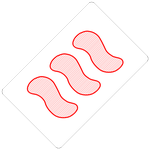

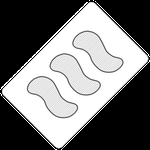

In [6]:
import os
from IPython import display


rgb_directory = 'resized-images'
greyscaled_directory = 'greyscaled-images'
image_filename = '3-red-striped-bean-315.png'

rgb_path = os.path.join(rgb_directory, image_filename)
display.display(display.Image(filename=rgb_path))
greyscaled_path = os.path.join(greyscaled_directory, image_filename)
display.display(display.Image(filename=greyscaled_path))

In [ ]:
import tensorflow as tf


with tf.Session() as session:
  saver = tf.train.Saver()